In [1]:
   %pip install seaborn
   %pip install statsmodels
   %pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class BakeryRegressionAnalysis:
    def __init__(self, data_path=None):
        self.data_path = data_path
        self.train_data = None
        self.validation_data = None
        self.test_data = None
        self.ols_model = None
        self.feature_names = []
        
    def load_and_split_data(self, df=None):
        """Load data and split into train/validation/test sets"""
        if df is not None:
            data = df.copy()
        else:
            # For demonstration, create sample data structure
            print("Using sample data structure - replace with your actual data loading")
            return
            
        # Ensure the 'Datum' column is in datetime format
        data['Datum'] = pd.to_datetime(data['Datum'])
        
        # If 'Weekday' column does not exist, create it
        if 'Weekday' not in data.columns:
            data['Weekday'] = data['Datum'].dt.day_name()
        
        # Define time ranges
        train_start = '2013-07-01'
        train_end = '2017-07-31'
        val_start = '2017-08-01'
        val_end = '2018-07-31'
        test_start = '2018-08-01'
        test_end = '2019-07-30'
        
        # Split data
        self.train_data = data[(data['Datum'] >= train_start) & (data['Datum'] <= train_end)]
        self.validation_data = data[(data['Datum'] >= val_start) & (data['Datum'] <= val_end)]
        self.test_data = data[(data['Datum'] >= test_start) & (data['Datum'] <= test_end)]
        
        print(f"Train shape: {self.train_data.shape}")
        print(f"Validation shape: {self.validation_data.shape}")
        print(f"Test shape: {self.test_data.shape}")
    
    def prepare_features(self, data):
        """Prepare features for regression analysis"""
        data = data.copy()
        data['Datum'] = pd.to_datetime(data['Datum'])
        
        # Add time-based features
        data['Month'] = data['Datum'].dt.month
        data['Day_of_Year'] = data['Datum'].dt.dayofyear
        data['Week_of_Year'] = data['Datum'].dt.isocalendar().week.astype(int)
        data['Quarter'] = data['Datum'].dt.quarter
        data['Year'] = data['Datum'].dt.year
        
        # Cyclical encoding
        data['Month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
        data['Month_cos'] = np.cos(2 * np.pi * data['Month'] / 12)
        data['Day_sin'] = np.sin(2 * np.pi * data['Day_of_Year'] / 365)
        data['Day_cos'] = np.cos(2 * np.pi * data['Day_of_Year'] / 365)
        data['Week_sin'] = np.sin(2 * np.pi * data['Week_of_Year'] / 52)
        data['Week_cos'] = np.cos(2 * np.pi * data['Week_of_Year'] / 52)
        
        # Fill missing values for key features
        numeric_cols = ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'Temp_Deviation']
        for col in numeric_cols:
            if col in data.columns:
                data[col] = data[col].fillna(data[col].median())
        
        binary_cols = ['KielerWoche', 'Is_Holiday']
        for col in binary_cols:
            if col in data.columns:
                data[col] = data[col].fillna(0)
        
        if 'Weather_Impression' in data.columns:
            data['Weather_Impression'] = data['Weather_Impression'].fillna('Unknown')
            
        return data
    
    def build_feature_matrix(self, data):
        """Build feature matrix for OLS regression"""
        Y = data['Umsatz']
        X_components = []
        
        # 1. Product categories (dummy variables)
        if 'Warengruppe' in data.columns:
            warengruppe_dummies = pd.get_dummies(data['Warengruppe'], prefix='Warengruppe', drop_first=True, dtype=int)
            X_components.append(warengruppe_dummies)
        
        # 2. Weekday dummies
        if 'Weekday' in data.columns:
            weekday_dummies = pd.get_dummies(data['Weekday'], prefix='Weekday', drop_first=True, dtype=int)
            X_components.append(weekday_dummies)
        
        # 3. Weather impression dummies
        if 'Weather_Impression' in data.columns:
            weather_dummies = pd.get_dummies(data['Weather_Impression'], prefix='Weather', drop_first=True, dtype=int)
            X_components.append(weather_dummies)
        
        # 4. Continuous weather variables
        continuous_vars = ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'Temp_Deviation']
        for var in continuous_vars:
            if var in data.columns:
                X_components.append(data[[var]])
        
        # 5. Binary variables
        binary_vars = ['Is_Holiday', 'KielerWoche']
        for var in binary_vars:
            if var in data.columns:
                X_components.append(data[[var]])
        
        # 6. Time-based features
        time_features = ['Month', 'Quarter', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'Week_sin', 'Week_cos']
        for var in time_features:
            if var in data.columns:
                X_components.append(data[[var]])
        
        # Combine all components
        X = pd.concat(X_components, axis=1)
        
        # Remove rows with NaN in X or Y
        valid_idx = Y.notna() & X.notna().all(axis=1)
        Y_clean = Y[valid_idx].reset_index(drop=True)
        X_clean = X[valid_idx].reset_index(drop=True)
        
        self.feature_names = list(X_clean.columns)
        
        return X_clean, Y_clean
    
    def fit_ols_model(self):
        """Fit OLS regression model"""
        if self.train_data is None:
            print("Please load data first using load_and_split_data()")
            return
        
        # Prepare training data
        train_prepared = self.prepare_features(self.train_data)
        X_train, y_train = self.build_feature_matrix(train_prepared)
        
        # Add constant term
        X_train_const = sm.add_constant(X_train)
        
        # Fit OLS model
        self.ols_model = sm.OLS(y_train, X_train_const).fit()
        
        print("=== OLS Model Summary ===")
        print(self.ols_model.summary())
        
        return self.ols_model
    
    def evaluate_model(self, data_type='validation'):
        """Evaluate model performance"""
        if self.ols_model is None:
            print("Please fit the model first using fit_ols_model()")
            return
        
        # Select data
        if data_type == 'validation':
            eval_data = self.validation_data
        elif data_type == 'test':
            eval_data = self.test_data
        else:
            eval_data = self.train_data
        
        # Prepare evaluation data
        eval_prepared = self.prepare_features(eval_data)
        X_eval, y_eval = self.build_feature_matrix(eval_prepared)
        X_eval_const = sm.add_constant(X_eval)
        
        # Make predictions
        y_pred = self.ols_model.predict(X_eval_const)
        
        # Calculate metrics
        mse = mean_squared_error(y_eval, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_eval, y_pred)
        r2 = r2_score(y_eval, y_pred)
        
        print(f"\n=== Model Evaluation on {data_type.title()} Set ===")
        print(f"R² Score: {r2:.4f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"MSE: {mse:.2f}")
        
        return {'r2': r2, 'rmse': rmse, 'mae': mae, 'mse': mse, 'predictions': y_pred, 'actual': y_eval}
    
    def plot_model_diagnostics(self):
        """Create diagnostic plots for the model"""
        if self.ols_model is None:
            print("Please fit the model first using fit_ols_model()")
            return
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('OLS Model Diagnostic Plots', fontsize=16, fontweight='bold')
        
        # Get residuals and fitted values
        residuals = self.ols_model.resid
        fitted_values = self.ols_model.fittedvalues
        
        # 1. Residuals vs Fitted
        axes[0, 0].scatter(fitted_values, residuals, alpha=0.6)
        axes[0, 0].axhline(y=0, color='red', linestyle='--')
        axes[0, 0].set_xlabel('Fitted Values')
        axes[0, 0].set_ylabel('Residuals')
        axes[0, 0].set_title('Residuals vs Fitted')
        
        # 2. Q-Q Plot
        from scipy import stats
        stats.probplot(residuals, dist="norm", plot=axes[0, 1])
        axes[0, 1].set_title('Normal Q-Q Plot')
        
        # 3. Histogram of Residuals
        axes[0, 2].hist(residuals, bins=50, density=True, alpha=0.7)
        axes[0, 2].set_xlabel('Residuals')
        axes[0, 2].set_ylabel('Density')
        axes[0, 2].set_title('Distribution of Residuals')
        
        # 4. Feature Importance (Top 15 coefficients by absolute value)
        coef_df = pd.DataFrame({
            'feature': self.ols_model.params.index[1:],  # Exclude constant
            'coefficient': self.ols_model.params.values[1:],
            'p_value': self.ols_model.pvalues.values[1:]
        })
        coef_df['abs_coef'] = abs(coef_df['coefficient'])
        top_features = coef_df.nlargest(15, 'abs_coef')
        
        y_pos = np.arange(len(top_features))
        axes[1, 0].barh(y_pos, top_features['coefficient'])
        axes[1, 0].set_yticks(y_pos)
        axes[1, 0].set_yticklabels(top_features['feature'], fontsize=8)
        axes[1, 0].set_xlabel('Coefficient Value')
        axes[1, 0].set_title('Top 15 Feature Coefficients')
        
        # 5. Actual vs Predicted (validation set)
        val_results = self.evaluate_model('validation')
        if val_results:
            axes[1, 1].scatter(val_results['actual'], val_results['predictions'], alpha=0.6)
            axes[1, 1].plot([val_results['actual'].min(), val_results['actual'].max()], 
                           [val_results['actual'].min(), val_results['actual'].max()], 'r--', lw=2)
            axes[1, 1].set_xlabel('Actual Values')
            axes[1, 1].set_ylabel('Predicted Values')
            axes[1, 1].set_title(f'Actual vs Predicted (R² = {val_results["r2"]:.3f})')
        
        # 6. Residuals vs Leverage
        leverage = self.ols_model.get_influence().hat_matrix_diag
        axes[1, 2].scatter(leverage, residuals, alpha=0.6)
        axes[1, 2].set_xlabel('Leverage')
        axes[1, 2].set_ylabel('Residuals')
        axes[1, 2].set_title('Residuals vs Leverage')
        
        plt.tight_layout()
        plt.show()
    
    def plot_time_series_analysis(self):
        """Plot time series analysis of sales"""
        if self.train_data is None:
            print("Please load data first")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('Time Series Analysis of Bakery Sales', fontsize=16, fontweight='bold')
        
        # Combine all data for time series plots
        all_data = pd.concat([self.train_data, self.validation_data, self.test_data])
        all_data = all_data.sort_values('Datum')
        
        # 1. Sales over time
        axes[0, 0].plot(all_data['Datum'], all_data['Umsatz'], alpha=0.7, linewidth=0.5)
        axes[0, 0].set_xlabel('Date')
        axes[0, 0].set_ylabel('Sales (Umsatz)')
        axes[0, 0].set_title('Sales Over Time')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # 2. Monthly average sales
        monthly_sales = all_data.groupby(all_data['Datum'].dt.to_period('M'))['Umsatz'].mean()
        axes[0, 1].plot(monthly_sales.index.astype(str), monthly_sales.values, marker='o')
        axes[0, 1].set_xlabel('Month')
        axes[0, 1].set_ylabel('Average Sales')
        axes[0, 1].set_title('Monthly Average Sales')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # 3. Sales by weekday
        weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        weekday_sales = all_data.groupby('Weekday')['Umsatz'].mean().reindex(weekday_order)
        axes[1, 0].bar(weekday_sales.index, weekday_sales.values)
        axes[1, 0].set_xlabel('Weekday')
        axes[1, 0].set_ylabel('Average Sales')
        axes[1, 0].set_title('Average Sales by Weekday')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # 4. Sales by product category
        if 'Warengruppe' in all_data.columns:
            category_sales = all_data.groupby('Warengruppe')['Umsatz'].mean().sort_values(ascending=False)
            axes[1, 1].bar(category_sales.index, category_sales.values)
            axes[1, 1].set_xlabel('Product Category')
            axes[1, 1].set_ylabel('Average Sales')
            axes[1, 1].set_title('Average Sales by Product Category')
            axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    def generate_insights(self):
        """Generate business insights from the model"""
        if self.ols_model is None:
            print("Please fit the model first")
            return
        
        print("\n" + "="*60)
        print("BUSINESS INSIGHTS FROM REGRESSION ANALYSIS")
        print("="*60)
        
        # Model performance
        print(f"\n📊 MODEL PERFORMANCE:")
        print(f"   • R-squared: {self.ols_model.rsquared:.3f} ({self.ols_model.rsquared*100:.1f}% of variance explained)")
        print(f"   • Adjusted R-squared: {self.ols_model.rsquared_adj:.3f}")
        print(f"   • F-statistic: {self.ols_model.fvalue:.1f}")
        
        # Top positive factors
        coef_df = pd.DataFrame({
            'feature': self.ols_model.params.index,
            'coefficient': self.ols_model.params.values,
            'p_value': self.ols_model.pvalues.values
        })
        
        significant_features = coef_df[coef_df['p_value'] < 0.05]
        top_positive = significant_features.nlargest(5, 'coefficient')
        top_negative = significant_features.nsmallest(5, 'coefficient')
        
        print(f"\n🔝 TOP SALES DRIVERS:")
        for _, row in top_positive.iterrows():
            if row['feature'] != 'const':
                print(f"   • {row['feature']}: +{row['coefficient']:.2f} (p={row['p_value']:.3f})")
        
        print(f"\n🔻 TOP SALES INHIBITORS:")
        for _, row in top_negative.iterrows():
            if row['feature'] != 'const':
                print(f"   • {row['feature']}: {row['coefficient']:.2f} (p={row['p_value']:.3f})")
        
        # Weather insights
        weather_features = significant_features[significant_features['feature'].str.contains('Temperatur|Weather|Bewoelkung')]
        if not weather_features.empty:
            print(f"\n🌤️ WEATHER IMPACT:")
            for _, row in weather_features.iterrows():
                print(f"   • {row['feature']}: {row['coefficient']:.2f} (p={row['p_value']:.3f})")
        
        # Time-based insights
        weekday_features = significant_features[significant_features['feature'].str.contains('Weekday')]
        if not weekday_features.empty:
            print(f"\n📅 WEEKDAY PATTERNS:")
            for _, row in weekday_features.iterrows():
                print(f"   • {row['feature']}: {row['coefficient']:.2f} (p={row['p_value']:.3f})")

# Example usage (replace with your actual data loading)
def main():
    """Main function to run the analysis"""
    analyzer = BakeryRegressionAnalysis()
    
    print("Bakery Sales Regression Analysis")
    print("="*40)
    print("\nTo use this analysis with your data:")
    print("1. Load your CSV file into a pandas DataFrame")
    print("2. Call analyzer.load_and_split_data(your_dataframe)")
    print("3. Call analyzer.fit_ols_model()")
    print("4. Call analyzer.plot_model_diagnostics()")
    print("5. Call analyzer.plot_time_series_analysis()")
    print("6. Call analyzer.generate_insights()")
    
    # Example with sample data structure
    print("\nSample code structure:")
    print("""
    # Load your data
    df = pd.read_csv('your_data_file.csv')
    
    # Initialize analyzer
    analyzer = BakeryRegressionAnalysis()
    
    # Run analysis
    analyzer.load_and_split_data(df)
    analyzer.fit_ols_model()
    analyzer.plot_model_diagnostics()
    analyzer.plot_time_series_analysis()
    analyzer.generate_insights()
    """)

if __name__ == "__main__":
    main()

Bakery Sales Regression Analysis

To use this analysis with your data:
1. Load your CSV file into a pandas DataFrame
2. Call analyzer.load_and_split_data(your_dataframe)
3. Call analyzer.fit_ols_model()
4. Call analyzer.plot_model_diagnostics()
5. Call analyzer.plot_time_series_analysis()
6. Call analyzer.generate_insights()

Sample code structure:

    # Load your data
    df = pd.read_csv('your_data_file.csv')
    
    # Initialize analyzer
    analyzer = BakeryRegressionAnalysis()
    
    # Run analysis
    analyzer.load_and_split_data(df)
    analyzer.fit_ols_model()
    analyzer.plot_model_diagnostics()
    analyzer.plot_time_series_analysis()
    analyzer.generate_insights()
    


Train shape: (7517, 15)
Validation shape: (1839, 15)
Test shape: (351, 15)
=== OLS Model Summary ===
                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     680.3
Date:                Thu, 12 Jun 2025   Prob (F-statistic):               0.00
Time:                        17:04:33   Log-Likelihood:                -43183.
No. Observations:                7487   AIC:                         8.643e+04
Df Residuals:                    7457   BIC:                         8.663e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------

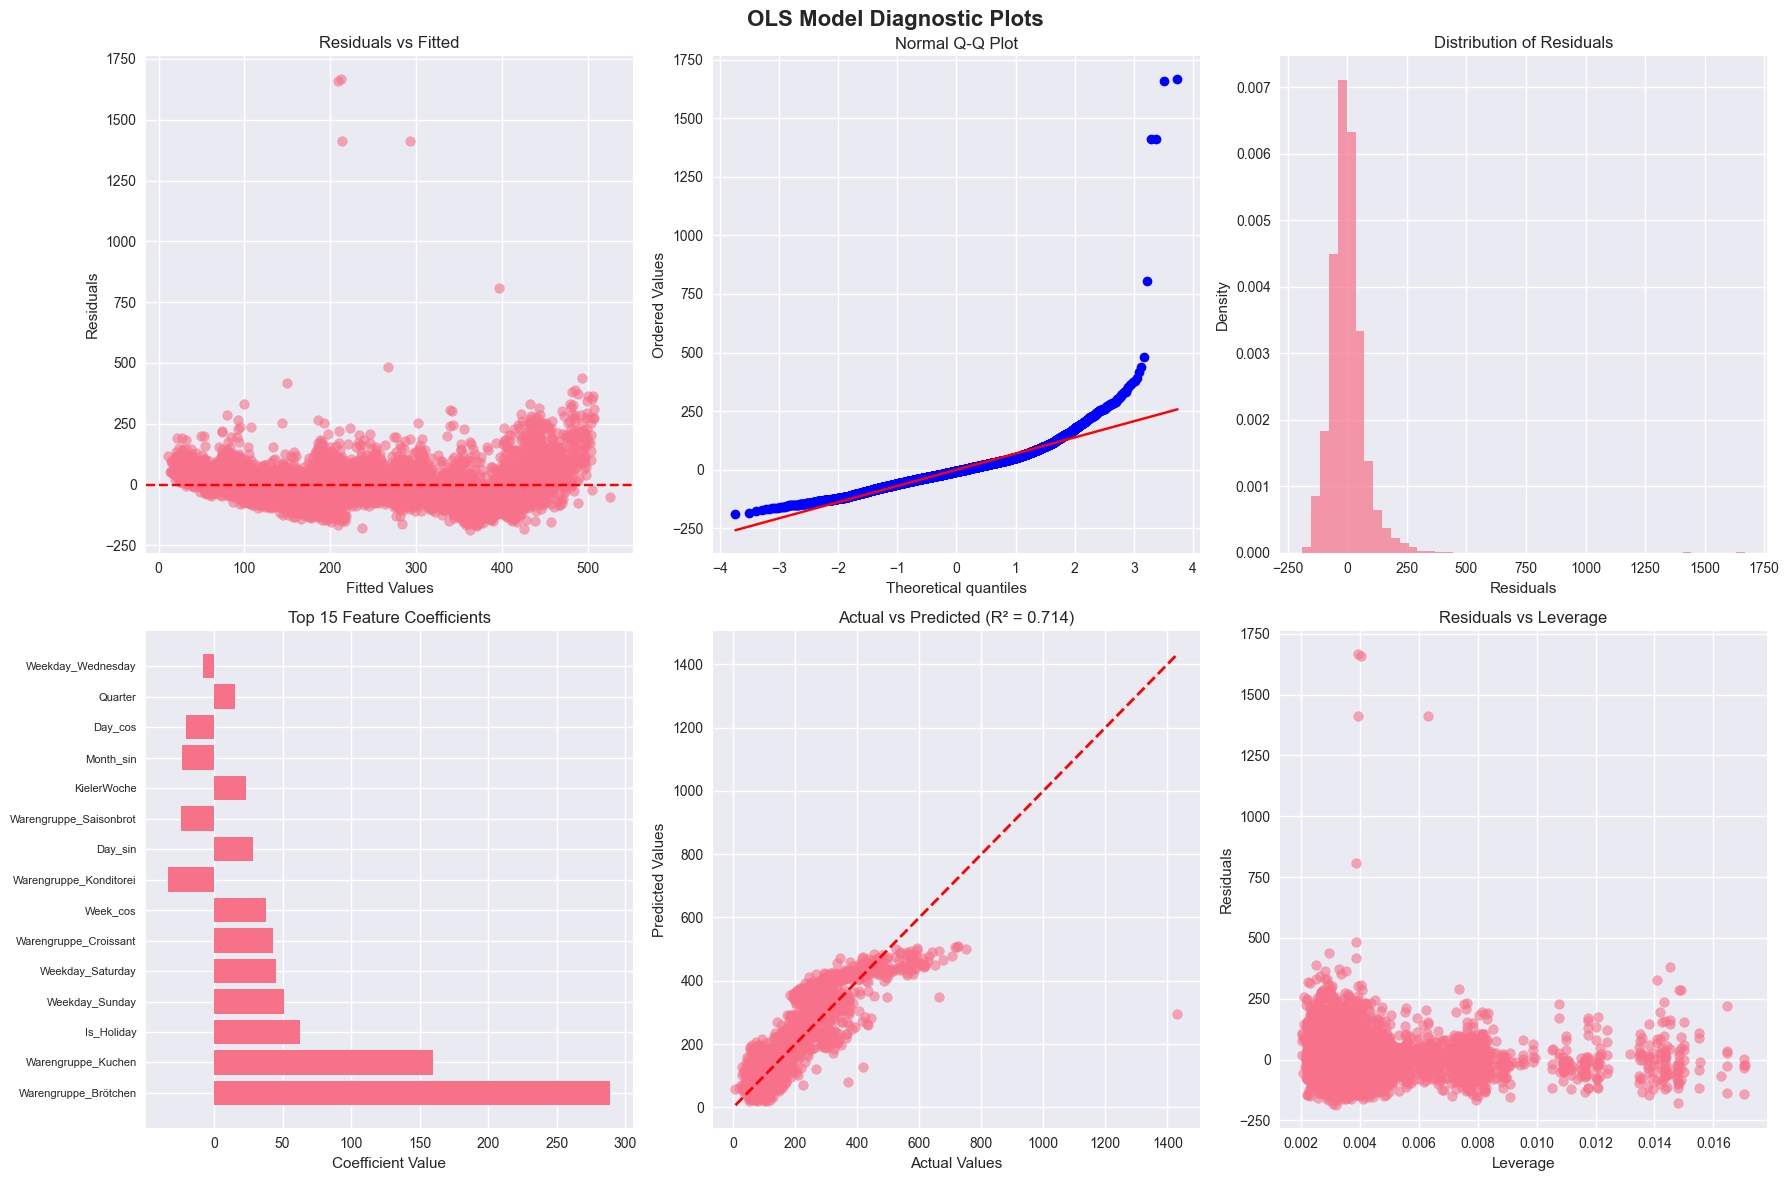

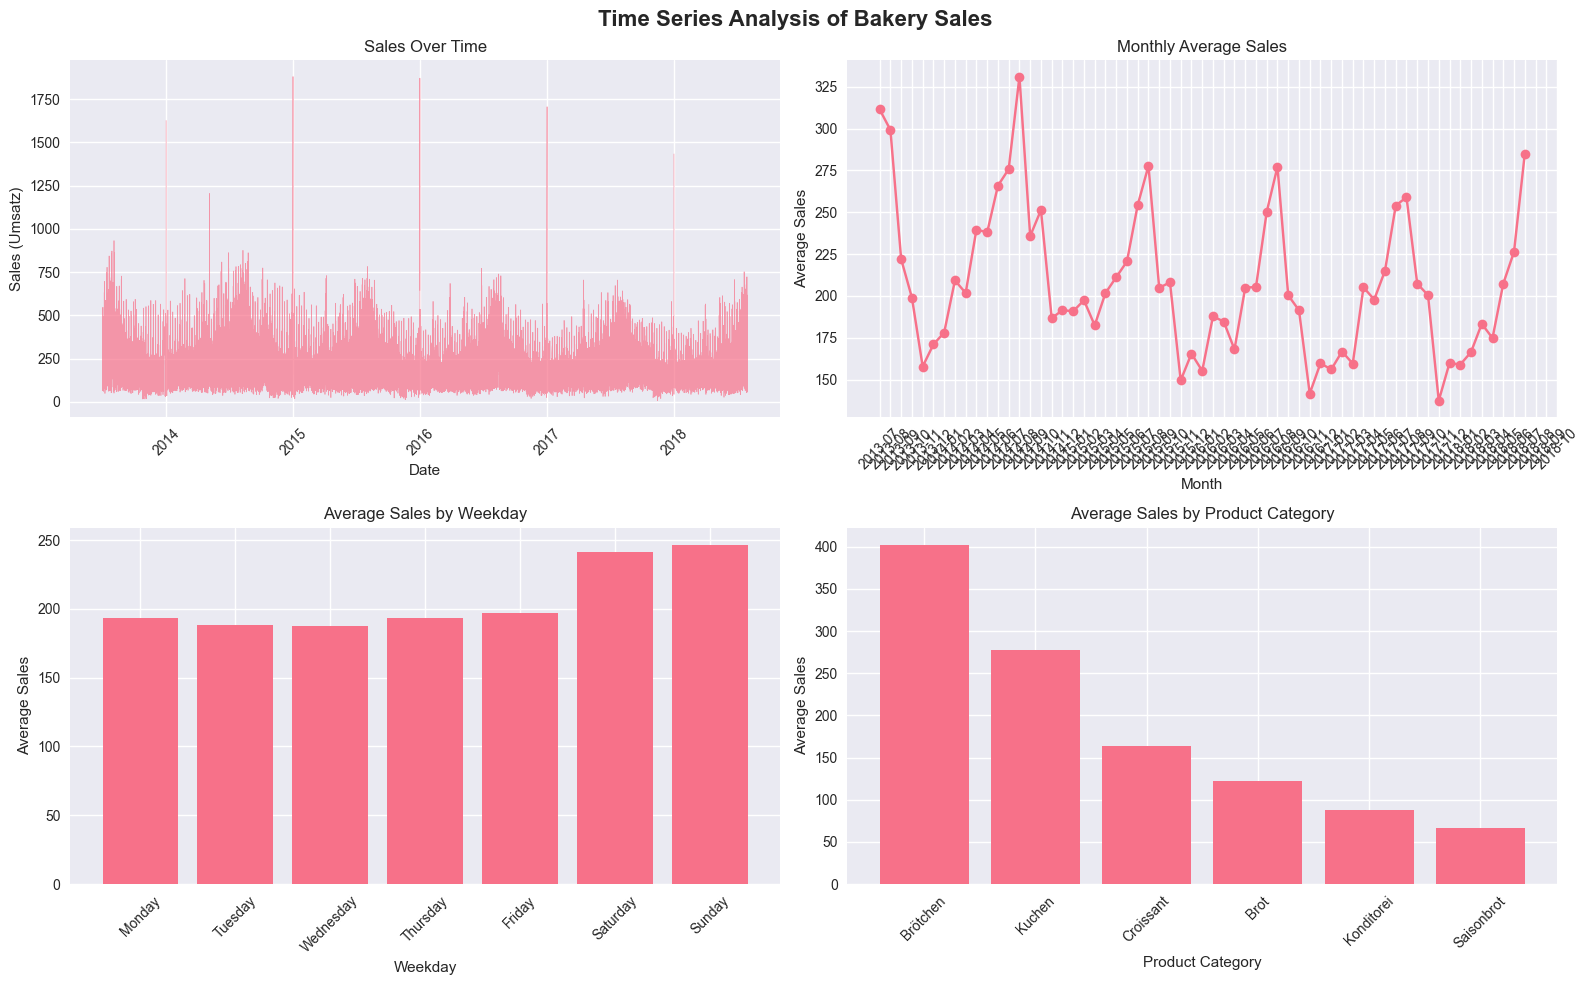


BUSINESS INSIGHTS FROM REGRESSION ANALYSIS

📊 MODEL PERFORMANCE:
   • R-squared: 0.726 (72.6% of variance explained)
   • Adjusted R-squared: 0.725
   • F-statistic: 680.3

🔝 TOP SALES DRIVERS:
   • Warengruppe_Brötchen: +289.16 (p=0.000)
   • Warengruppe_Kuchen: +159.52 (p=0.000)
   • Is_Holiday: +62.55 (p=0.000)
   • Weekday_Sunday: +51.15 (p=0.000)
   • Weekday_Saturday: +45.09 (p=0.000)

🔻 TOP SALES INHIBITORS:
   • Warengruppe_Konditorei: -33.17 (p=0.000)
   • Warengruppe_Saisonbrot: -23.97 (p=0.000)
   • Month_sin: -23.54 (p=0.007)
   • Weekday_Wednesday: -8.32 (p=0.014)
   • Weekday_Tuesday: -8.03 (p=0.017)

🌤️ WEATHER IMPACT:
   • Temperatur: 6.19 (p=0.000)

📅 WEEKDAY PATTERNS:
   • Weekday_Saturday: 45.09 (p=0.000)
   • Weekday_Sunday: 51.15 (p=0.000)
   • Weekday_Tuesday: -8.03 (p=0.017)
   • Weekday_Wednesday: -8.32 (p=0.014)


In [9]:
df = pd.read_csv('0_DataPreparation/initialdata/merged_data_temperature+holidays+weather_impressions.csv')

analyzer = BakeryRegressionAnalysis()

analyzer.load_and_split_data(df)
analyzer.fit_ols_model()
analyzer.plot_model_diagnostics()
analyzer.plot_time_series_analysis()
analyzer.generate_insights()
